### 라이브러리 및 tensorflow 1.x 설정

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

tf.compat.v1.disable_eager_execution()

### 데이터 읽어오기

In [2]:
df = pd.read_csv('./monthly_temperature.csv', encoding='cp949')
df

,yyyy/MM/dd,Mean(℃),Min(℃),Max(℃)
0,1973-01-01,1.2,-2.5,5.6
1,1973-02-01,1.8,-2.5,6.7
2,1973-03-01,5.1,-0.6,11.4
3,1973-04-01,12.8,6.8,18.7
4,1973-05-01,16.8,11.4,22.3
...,...,...,...,...
573,2020-10-01,14.0,8.7,20.2
574,2020-11-01,8.8,3.8,14.3
575,2020-12-01,0.7,-4.0,6.3
576,2021-01-01,-5.8,-0.4,4.7


In [3]:
# 표준화
def data_standardization(x):
    x_np = np.asarray(x)
    return (x_np - x_np.mean()) / x_np.std()
 
# 너무 작거나 너무 큰 값이 학습을 방해하는 것을 방지하는 역할
# x가 양수라는 가정 하에 최소값과 최대값을 이용하여 0~1 사이의 값으로 변환
# Min-Max scaling
def min_max_scaling(x):
    x_np = np.asarray(x)
    return (x_np - x_np.min()) / (x_np.max() - x_np.min() + 1e-7) # 1e-7은 0으로 나누는 오류 예방 목적
 
# 정규화된 값을 원래의 값으로 변환
def reverse_min_max_scaling(org_x, x):
    org_x_np = np.asarray(org_x) 
    x_np = np.asarray(x)
    
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

In [4]:
input_data_column_cnt = 3  # 입력데이터의 컬럼 개수(Variable 개수)
output_data_column_cnt = 1 # 결과데이터의 컬럼 개수

seq_length = 28            # 1개 시퀀스의 길이(시계열 데이터 입력 개수)
rnn_cell_hidden_dim = 10   # 각 셀의 (hidden) 출력 크기
forget_bias = 1.0          # 망각편향(기본값 1.0)
num_stacked_layers = 1     # stacked LSTM layers 개수
keep_prob = 1.0            # dropout할 때 keep할 비율

epoch_num = 1500          
learning_rate = 0.005       # 학습률

In [5]:
temperature_file_name = 'monthly_temperature.csv'
names = ['yyyy/MM/dd','Mean(℃)','Min(℃)','Max(℃)']

raw_dataframe = pd.read_csv(temperature_file_name, names=names, encoding='cp949')
raw_dataframe.info() # 데이터 정보 출력

# 날짜열 제거
del raw_dataframe['yyyy/MM/dd']

temperature_info = raw_dataframe.values[1:].astype(np.float)

print("temperature_info.shape: ", temperature_info.shape)
print("temperature_info[0]: ", temperature_info[0])
print('yyyy/MM 값 삭제 후 rea_dateframe.info')

raw_dataframe.info() # 데이터 정보 출력

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579 entries, 0 to 578
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   yyyy/MM/dd  579 non-null    object
 1   Mean(℃)     579 non-null    object
 2   Min(℃)      579 non-null    object
 3   Max(℃)      579 non-null    object
dtypes: object(4)
memory usage: 18.2+ KB
temperature_info.shape:  (578, 3)
temperature_info[0]:  [ 1.2 -2.5  5.6]
yyyy/MM 값 삭제 후 rea_dateframe.info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579 entries, 0 to 578
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Mean(℃)  579 non-null    object
 1   Min(℃)   579 non-null    object
 2   Max(℃)   579 non-null    object
dtypes: object(3)
memory usage: 13.7+ KB


In [6]:
# 데이터 전처리
temperature = temperature_info[:,:-1]
norm_temp = min_max_scaling(temperature)

print("temperature.shape: ", temperature.shape)
print("temperature[0]: ", temperature[0])
print("norm_temp[0]: ", norm_temp[0])
print("="*10)

max_temperature = temperature_info[:,-1:]
norm_max_temp = min_max_scaling(max_temperature)

print("max_temperature.shape: ", max_temperature.shape)
print("max_temperature[0]: ", max_temperature[0])
print("norm_max_temp[0]: ", norm_max_temp[0])
print("="*10)

x = np.concatenate((norm_temp, norm_max_temp), axis=1)
print("x.shape: ", x.shape)
print("x[0]: ", x[0])    # x의 첫 값
print("x[-1]: ", x[-1])  # x의 마지막 값
print("="*10)

y = x[:, [0]]
print("y[0]: ",y[0])     # y의 첫 값
print("y[-1]: ",y[-1])   # y의 마지막 값

temperature.shape:  (578, 2)
temperature[0]:  [ 1.2 -2.5]
norm_temp[0]:  [0.29842932 0.20157068]
max_temperature.shape:  (578, 1)
max_temperature[0]:  [5.6]
norm_max_temp[0]:  [0.15805471]
x.shape:  (578, 3)
x[0]:  [0.29842932 0.20157068 0.15805471]
x[-1]:  [0.32984293 0.44764398 0.32218845]
y[0]:  [0.29842932]
y[-1]:  [0.32984293]


In [7]:
dataX = [] # 입력으로 사용될 Sequence Data
dataY = [] # 출력으로 사용

for i in range(0, len(y) - seq_length):
    _x = x[i : i+seq_length]
    _y = y[i + seq_length] # 다음 나타날 기온(정답)
    
    if i == 0:
        print(_x, "->", _y) # 첫번째 행만 출력해 봄
    
    dataX.append(_x) # dataX 리스트에 추가
    dataY.append(_y) # dataY 리스트에 추가

[[0.29842932 0.20157068 0.15805471]
 [0.31413612 0.20157068 0.19148936]
 [0.40052356 0.2513089  0.3343465 ]
 [0.60209424 0.44502618 0.556231  ]
 [0.70680628 0.56544502 0.66565349]
 [0.81151832 0.69633508 0.77203647]
 [0.96335078 0.85602094 0.94528875]
 [0.95549738 0.85340314 0.9331307 ]
 [0.78272251 0.66492146 0.7568389 ]
 [0.60994764 0.47120419 0.56231003]
 [0.42146597 0.28795811 0.34042553]
 [0.23560209 0.10209424 0.12462006]
 [0.21204188 0.07853403 0.12158055]
 [0.2460733  0.12827225 0.11246201]
 [0.37696335 0.2513089  0.28267477]
 [0.56806283 0.41623037 0.51367781]
 [0.70680628 0.55759162 0.67781155]
 [0.78272251 0.64921466 0.7568389 ]
 [0.85078534 0.78272251 0.77203647]
 [0.92146597 0.81675392 0.89665653]
 [0.78272251 0.64397906 0.77507599]
 [0.61518324 0.46858639 0.5775076 ]
 [0.42146597 0.28795811 0.35866261]
 [0.28272251 0.17277487 0.1550152 ]
 [0.23821989 0.13089005 0.10030395]
 [0.27486911 0.15445026 0.14893617]
 [0.39528796 0.2591623  0.31610942]
 [0.59162304 0.44764398 0.54

### 학습용/테스트용 데이터 생성

In [8]:
# 전체 70%를 학습용 데이터로 사용
train_size = int(len(dataY) * 0.7)

# 나머지(30%)를 테스트용 데이터로 사용
test_size = len(dataY) - train_size

# 데이터를 잘라 학습용 데이터 생성
trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])

# 데이터를 잘라 테스트용 데이터 생성
testX = np.array(dataX[train_size:len(dataX)])
testY = np.array(dataY[train_size:len(dataY)])

In [9]:
# 텐서플로우 플레이스홀더 생성
# 입력 X, 출력 Y를 생성한다
X = tf.placeholder(tf.float32, [None, seq_length, input_data_column_cnt])
print("X: ", X)

Y = tf.placeholder(tf.float32, [None, 1])
print("Y: ", Y)

# 검증용 측정지표를 산출하기 위한 targets, predictions를 생성한다
targets = tf.placeholder(tf.float32, [None, 1])
print("targets: ", targets)

predictions = tf.placeholder(tf.float32, [None, 1])
print("predictions: ", predictions)

X:  Tensor("Placeholder:0", shape=(None, 28, 3), dtype=float32)
Y:  Tensor("Placeholder_1:0", shape=(None, 1), dtype=float32)
targets:  Tensor("Placeholder_2:0", shape=(None, 1), dtype=float32)
predictions:  Tensor("Placeholder_3:0", shape=(None, 1), dtype=float32)


### LSTM 네트워크 생성

In [10]:
def lstm_cell():
    # LSTM셀을 생성
    # num_units: 각 Cell 출력 크기
    # forget_bias:  to the biases of the forget gate 
    #              (default: 1)  in order to reduce the scale of forgetting in the beginning of the training.
    # state_is_tuple: True ==> accepted and returned states are 2-tuples of the c_state and m_state.
    # state_is_tuple: False ==> they are concatenated along the column axis.
    cell = tf.compat.v1.nn.rnn_cell.LSTMCell(num_units=rnn_cell_hidden_dim, 
                                        forget_bias=forget_bias, state_is_tuple=True, activation=tf.nn.softsign)
    if keep_prob < 1.0:
        cell = tf.compat.v1.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell

# num_stacked_layers개의 층으로 쌓인 Stacked RNNs 생성
stackedRNNs = [lstm_cell() for _ in range(num_stacked_layers)]
multi_cells = tf.compat.v1.nn.rnn_cell.MultiRNNCell(stackedRNNs, state_is_tuple=True) if num_stacked_layers > 1 else lstm_cell()

# RNN Cell(여기서는 LSTM셀임)들을 연결
hypothesis, _states = tf.compat.v1.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)
print("hypothesis: ", hypothesis)

# 과거 기온을 이용해서 다음날의 기온을 예측하기 때문에 MANY-TO-ONE 형태
hypothesis = tf.compat.v1.layers.dense(inputs=hypothesis[:, -1], units=1, activation=tf.nn.relu)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


C:\Users\LG\anaconda3\lib\site-packages\tensorflow\python\keras\layers\legacy_rnn\rnn_cell_impl.py:903: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.LSTMCell` is deprecated and will be "


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\LG\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


hypothesis:  Tensor("rnn/transpose_1:0", shape=(None, 28, 10), dtype=float32)


C:\Users\LG\anaconda3\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\LG\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [11]:
# 손실함수로 평균제곱오차 사용
loss = tf.reduce_sum(tf.square(hypothesis - Y))

# 최적화함수로 AdamOptimizer 사용
optimizer = tf.train.AdamOptimizer(learning_rate)

train = optimizer.minimize(loss)

# RMSE(Root Mean Square Error)
# 제곱오차의 평균을 구하고 다시 제곱근을 구해서 평균 오차 계산
rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(targets, predictions)))

In [12]:
train_error_summary = [] # 학습용 데이터의 오류를 중간 기록
test_error_summary = []  # 테스트용 데이터의 오류를 중간 기록
test_predict = ''        # 테스트용데이터로 예측한 결과

sess = tf.Session()
sess.run(tf.global_variables_initializer())

# 학습
start_time = datetime.datetime.now() # 시작시간을 기록한다
print('학습을 시작합니다...')

for epoch in range(epoch_num):
    _, _loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
    if ((epoch+1) % 100 == 0) or (epoch == epoch_num-1): # 100번째마다 또는 마지막 epoch인 경우
        # 학습용데이터로 rmse오차를 구한다
        train_predict = sess.run(hypothesis, feed_dict={X: trainX})
        train_error = sess.run(rmse, feed_dict={targets: trainY, predictions: train_predict})
        train_error_summary.append(train_error)

        # 테스트용데이터로 rmse오차를 구한다
        test_predict = sess.run(hypothesis, feed_dict={X: testX})
        test_error = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
        test_error_summary.append(test_error)
        
        # 현재 오류를 출력한다
        print("epoch: {}, train_error(A): {}, test_error(B): {}, B-A: {}".format(epoch+1, train_error, test_error, test_error-train_error))
        
end_time = datetime.datetime.now()   # 종료시간을 기록한다
elapsed_time = end_time - start_time # 경과시간을 구한다

print('elapsed_time:',elapsed_time)
print('elapsed_time per epoch:',elapsed_time/epoch_num)

학습을 시작합니다...
epoch: 100, train_error(A): 0.1869046539068222, test_error(B): 0.19135485589504242, B-A: 0.004450201988220215
epoch: 200, train_error(A): 0.04109957441687584, test_error(B): 0.04564877226948738, B-A: 0.004549197852611542
epoch: 300, train_error(A): 0.03627297654747963, test_error(B): 0.04086718708276749, B-A: 0.004594210535287857
epoch: 400, train_error(A): 0.035150062292814255, test_error(B): 0.039462022483348846, B-A: 0.004311960190534592
epoch: 500, train_error(A): 0.034406065940856934, test_error(B): 0.03839866444468498, B-A: 0.003992598503828049
epoch: 600, train_error(A): 0.033740293234586716, test_error(B): 0.03744424134492874, B-A: 0.0037039481103420258
epoch: 700, train_error(A): 0.03309622034430504, test_error(B): 0.03654767945408821, B-A: 0.0034514591097831726
epoch: 800, train_error(A): 0.03246458247303963, test_error(B): 0.03570527955889702, B-A: 0.0032406970858573914
epoch: 900, train_error(A): 0.031870562583208084, test_error(B): 0.03496309369802475, B-A: 0.

input_data_column_cnt: 3,output_data_column_cnt: 1,seq_length: 28,rnn_cell_hidden_dim: 10,forget_bias: 1.0,num_stacked_layers: 1,keep_prob: 1.0,epoch_num: 1500,learning_rate: 0.005,train_error: 0.030280298,test_error: 0.03373749,min_test_error: 0.03373749


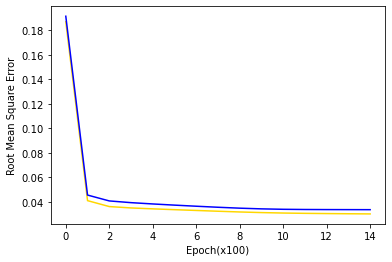

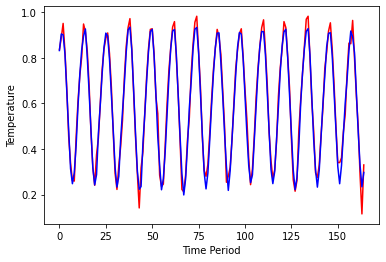

In [13]:
# 하이퍼파라미터 출력
print('input_data_column_cnt:', input_data_column_cnt, end='')
print(',output_data_column_cnt:', output_data_column_cnt, end='')

print(',seq_length:', seq_length, end='')
print(',rnn_cell_hidden_dim:', rnn_cell_hidden_dim, end='')
print(',forget_bias:', forget_bias, end='')
print(',num_stacked_layers:', num_stacked_layers, end='')
print(',keep_prob:', keep_prob, end='')

print(',epoch_num:', epoch_num, end='')
print(',learning_rate:', learning_rate, end='')

print(',train_error:', train_error_summary[-1], end='')
print(',test_error:', test_error_summary[-1], end='')
print(',min_test_error:', np.min(test_error_summary))

# 결과 그래프 출력
plt.figure(1)
plt.plot(train_error_summary, 'gold')
plt.plot(test_error_summary, 'b')
plt.xlabel('Epoch(x100)')
plt.ylabel('Root Mean Square Error')

plt.figure(2)
plt.plot(testY, 'r')
plt.plot(test_predict, 'b')
plt.xlabel('Time Period')
plt.ylabel('Temperature')
plt.show()

In [14]:
# sequence length만큼의 가장 최근 데이터를 슬라이싱한다
recent_data = np.array([x[len(x)-seq_length : ]])
print("recent_data.shape:", recent_data.shape)
print("recent_data:", recent_data)

# 다음달 기온 예측
test_predict = sess.run(hypothesis, feed_dict={X: recent_data})
print("test_predict_accuracy", test_predict[0])

test_predict = reverse_min_max_scaling(temperature, test_predict) # 기온 데이터 역정규화한다
print("Average temperature is", test_predict[0]) # 예측한 기온을 출력한다

recent_data.shape: (1, 28, 3)
recent_data: [[[0.47905759 0.34554974 0.42553191]
  [0.29581152 0.17801047 0.17933131]
  [0.27486911 0.14136126 0.17629179]
  [0.32984293 0.19895288 0.23100304]
  [0.46335078 0.31151832 0.40729483]
  [0.58115183 0.42931937 0.53495441]
  [0.7539267  0.57591623 0.76291793]
  [0.82460733 0.70418848 0.80243161]
  [0.91623036 0.82984293 0.87234042]
  [0.95287958 0.85340314 0.93009118]
  [0.83769633 0.73821989 0.79331307]
  [0.68062827 0.55759162 0.63829787]
  [0.4973822  0.35863874 0.44680851]
  [0.34031414 0.22251309 0.23404255]
  [0.34031414 0.23821989 0.2218845 ]
  [0.36125654 0.23560209 0.26443769]
  [0.47382199 0.31675393 0.41641337]
  [0.55235602 0.39005235 0.5106383 ]
  [0.73036649 0.60209424 0.69300912]
  [0.86387434 0.7486911  0.83890577]
  [0.86125654 0.78534031 0.78723404]
  [0.96335078 0.88743455 0.92097264]
  [0.79842932 0.70157068 0.75075988]
  [0.63350785 0.4947644  0.60182371]
  [0.4973822  0.36649215 0.4224924 ]
  [0.28534031 0.16230366 0.17933

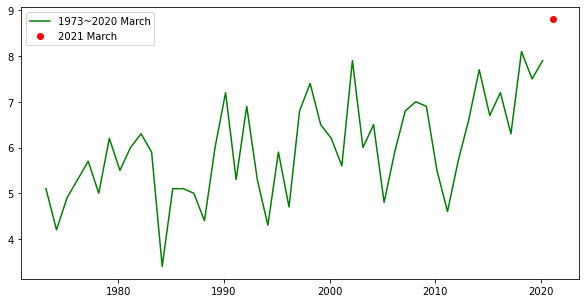

In [16]:
data = pd.read_csv('./monthly_temperature_only_mean.csv', index_col=0, encoding='cp949')

data.index = pd.to_datetime(data.index)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)

ax.plot(data['Avg(℃)'], color='g', label='1973~2020 March')

plt.scatter(pd.to_datetime("2021-03-01"), 8.802, color='r', label='2021 March')
plt.legend()
plt.show()